In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#PATHS

current_dir = os.path.dirname('./')

genuine_folder = os.path.join(current_dir, 'trainingSet/OfflineSignatures/Chinese/TrainingSet/OfflineGenuine/genuinetest')
forgeries_folder = os.path.join(current_dir, 'trainingSet/OfflineSignatures/Chinese/TrainingSet/OfflineForgeries/forgetest')   

In [3]:
#Genuine Data

genuine_data = []
for filename in os.listdir(genuine_folder):
    img = cv2.imread(os.path.join(genuine_folder, filename), 1)  # 1 : RGB Images
    height, width, depth = img.shape                             # getting gimesnions of image
    img_padded = cv2.copyMakeBorder(img, (400-(height-int(height/2))), (400-int(height/2)), (800-int(width/2)), (800-(width-int(width/2))), cv2.BORDER_CONSTANT, value = [255,255,255])
    genuine_data.append(img_padded)

In [4]:
#Forgeries Data

forgeries_data = []
for filename in os.listdir(forgeries_folder):
    img = cv2.imread(os.path.join(forgeries_folder, filename), 1)  # 1 : RGB Images
    height, width, depth = img.shape                             # getting gimesnions of image
    img_padded = cv2.copyMakeBorder(img, (400-(height-int(height/2))), (400-int(height/2)), (800-int(width/2)), (800-(width-int(width/2))), cv2.BORDER_CONSTANT, value = [255,255,255])
    forgeries_data.append(img_padded)

In [5]:
#Resized images 800 x 1600 numpy arrays

genuine_signs = np.array(genuine_data)
forged_signs = np.array(forgeries_data)

In [7]:
for i in range (10):
    print(genuine_signs[i].shape)

(800, 1600, 3)
(800, 1600, 3)
(800, 1600, 3)
(800, 1600, 3)
(800, 1600, 3)
(800, 1600, 3)
(800, 1600, 3)
(800, 1600, 3)
(800, 1600, 3)
(800, 1600, 3)


In [8]:
for i in range (10):
    print(forged_signs[i].shape)

(800, 1600, 3)
(800, 1600, 3)
(800, 1600, 3)
(800, 1600, 3)
(800, 1600, 3)
(800, 1600, 3)
(800, 1600, 3)
(800, 1600, 3)
(800, 1600, 3)
(800, 1600, 3)


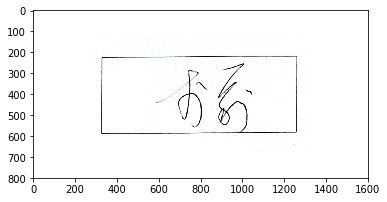

In [10]:
#Testing resized genuine image

imgplot = plt.imshow(genuine_signs[0])

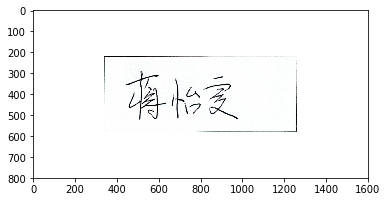

In [11]:
#Testing resized forged image

imgplot = plt.imshow(forged_signs[0])

In [12]:
#imports

from __future__ import print_function, division
import torch
import torch.nn as nn
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.autograd import Variable

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [14]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            nn.Dropout2d(p=.2),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.Dropout2d(p=.2),

            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.Dropout2d(p=.2),
        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5)
        )

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

In [15]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive